In [ ]:
# ==================== INSTALL & SETUP ====================
# %pip install tensorflow --quiet

# Load preprocessed data and label info
%run CleanData.ipynb

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, recall_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


Classes: [0 1 2 3 4 5] | Count: 6


In [ ]:
# ==================== DATA PREP ====================
# Convert to NumPy arrays if needed
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Normalize (if not done in CleanData)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


In [ ]:
# ==================== FOCAL LOSS DEFINITION ====================
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.5):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = self.alpha * K.pow(1 - y_pred, self.gamma)
        return K.sum(weight * cross_entropy, axis=1)


In [ ]:
# ==================== BUILD CNN ====================
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss=FocalLoss(gamma=2.0, alpha=0.5), metrics=['accuracy'])
model.summary()


c:\Users\plui0\anaconda3\envs\tfcpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 129, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 62, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       198,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,506 (802.76 KB)

 Trainable params: 205,506 (802.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==================== TRAIN MODEL ====================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8196 - loss: 0.2350 - val_accuracy: 0.9016 - val_loss: 0.0698
Epoch 2/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8196 - loss: 0.2350 - val_accuracy: 0.9016 - val_loss: 0.0698
Epoch 2/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8853 - loss: 0.1152 - val_accuracy: 0.9211 - val_loss: 0.0506
Epoch 3/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8853 - loss: 0.1152 - val_accuracy: 0.9211 - val_loss: 0.0506
Epoch 3/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9050 - loss: 0.0885 - val_accuracy: 0.9334 - val_loss: 0.0380
Epoch 4/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9050 - loss: 0.0885 - val_accuracy: 0.9334 - val_loss: 0.0380
Epoch 4/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9175 - loss: 0.0744 - val_accuracy: 0.9411 - val_loss: 0.0347
Epoch 5/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9175 - loss: 0.0744 - val_accuracy: 

In [ ]:
# ==================== EVALUATE MODEL ====================
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))


776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9539 - loss: 0.0213
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9539 - loss: 0.0213
Test Accuracy: 0.9676
Test Accuracy: 0.9676
776/776 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
776/776 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     18952
           1       0.78      0.78      0.78       556
           2       0.96      0.92      0.94      1448
           3       0.69      0.84      0.76       162
           4       1.00      0.98      0.99      1608
           5       0.96      0.87      0.91      2077

    accuracy                           0.97     24803
   macro avg       0.89      0.90      0.89     24803
weighted avg       0.97      0.97      0.97     24803

Recall (macro): 0.8962720474458701
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98

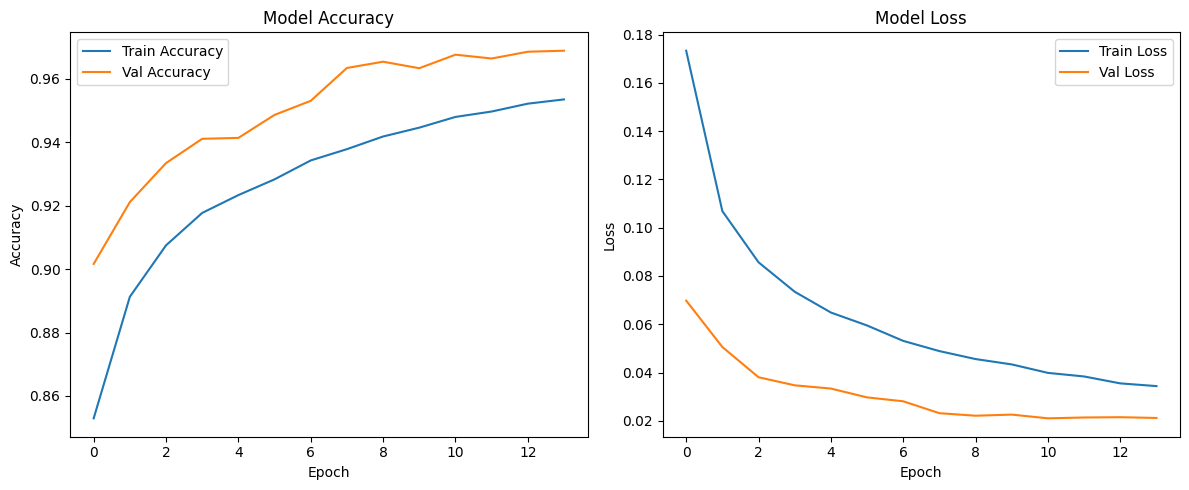

In [ ]:
# ==================== PLOT HISTORY ====================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


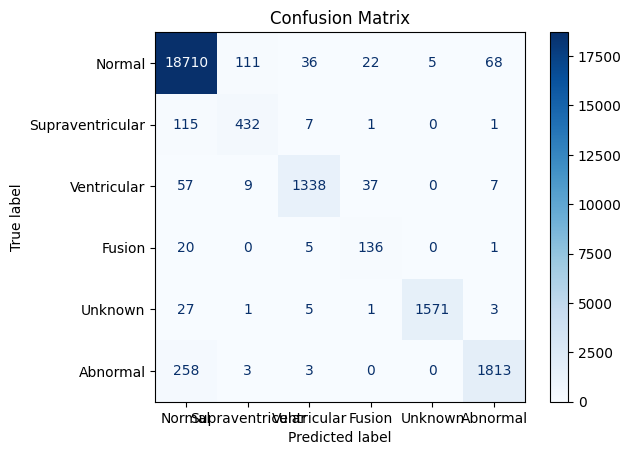

In [ ]:
# ==================== CONFUSION MATRIX ====================
label_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown', 'Abnormal']
cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
cmd = ConfusionMatrixDisplay(cm, display_labels=label_names)
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


C:\Users\plui0\AppData\Local\Temp\ipykernel_4084\800358297.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


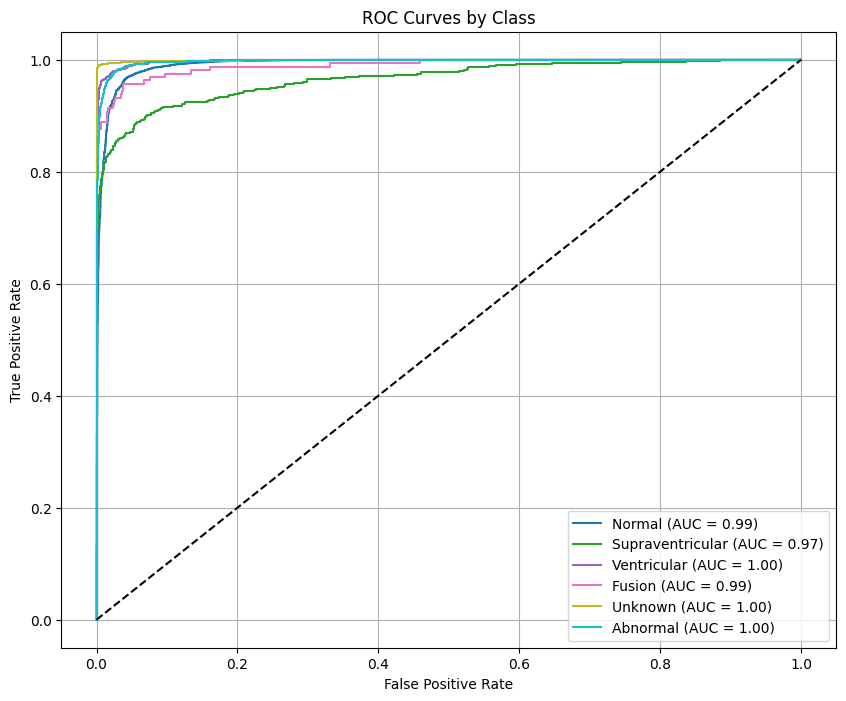

In [ ]:
# ==================== ROC & AUC ====================
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})", color=colors(i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
